In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

pd.options.display.max_columns = None # affiche toutes les colonnes lors de l'affichage des DataFrames
pd.options.display.float_format = '{:.2f}'.format # affiche les nombres à virgule flottante avec 2 décimales

# Analyse des données de circulation entre 2019 et 2024

# Import

In [2]:
# lecture des données de circulation
# les fichiers pèsent en tout 69Mo, donc on devrait pouvoir tout concaténer sans problème
df_raw = pd.DataFrame()
for annee in range(2019, 2025):
    df_temp = pd.read_parquet(f"../data/2-clean/circulations/slo_{annee}.parquet")
    df_temp['annee'] = annee
    df_raw = pd.concat([df_raw, df_temp], ignore_index=True)
    print(f"Année {annee} ajoutée ({df_temp.shape[0]:_} lignes) : df_raw.shape = {df_raw.shape}")

# aperçu des données
df_raw.shape

Année 2019 ajoutée (255_203 lignes) : df_raw.shape = (255203, 33)
Année 2020 ajoutée (170_511 lignes) : df_raw.shape = (425714, 33)
Année 2021 ajoutée (196_582 lignes) : df_raw.shape = (622296, 33)
Année 2022 ajoutée (245_865 lignes) : df_raw.shape = (868161, 33)
Année 2023 ajoutée (245_044 lignes) : df_raw.shape = (1113205, 33)
Année 2024 ajoutée (254_002 lignes) : df_raw.shape = (1367207, 33)


(1367207, 33)

In [3]:
# lecture des données sur les gares :
gares = pd.read_parquet("../data/2-clean/gares/gares-de-voyageurs.parquet")

# Merge

In [4]:
df = df_raw.copy()

# Récupère les infos de la gare d'origine
df = (
    df.merge(gares[['code_ci', 'Segment(s) DRG', 'code_departement', 'nom_departement', 'region']], 
             left_on='code_ci_origine',
             right_on='code_ci',
             how='left')
    .rename(columns={
        'Segment(s) DRG': 'segment_DRG_origine', 
        'code_departement': 'code_dpt_origine', 
        'nom_departement': 'nom_dpt_origine', 
        'region': 'region_origine'})
    .drop(columns=['code_ci']))

# Récupère les infos de la gare de destination
df = (
    df.merge(gares[['code_ci', 'Segment(s) DRG', 'code_departement', 'nom_departement', 'region']],
             left_on='code_ci_destination', 
             right_on='code_ci',
             how='left')
    .rename(columns={
        'Segment(s) DRG': 'segment_DRG_destination',
        'code_departement': 'code_dpt_destination',
        'nom_departement': 'nom_dpt_destination',
        'region': 'region_destination'})
    .drop(columns=['code_ci'])
)

In [5]:
# Ré-ajout de la catégorie de retard à l'arrivée, supprimée de l'ingestion
bins = [float("-inf"), -10, -5, 0, 5, 10, 15, 30, 60, float("inf")]
labels = ["-10-", "[-10,-5[", "[-5,0[", "[0,5[", "[5,10[", "[10,15[", "[15,30[", "[30,60[", "[60+]"]
df["ret_arrivee_cat"] = pd.cut(df["ret_arrivee"], bins=bins, labels=labels, right=False)

# Analyse

In [6]:
# top 10 des plus grands retards à l'arrivée : 
df.sort_values(by='ret_arrivee', ascending=False).head() 

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,arrivee_theorique,arrivee_observe,distance_totale,ret_depart,ret_arrivee,ret_arrivee_5min,ret_arrivee_10min,ret_arrivee_15min,ret_arrivee_30min,ret_arrivee_60min,duree_theorique,duree_theorique_cat,duree_observee,mois,num_semaine,jour_semaine,heure_depart,heure_arrivee,annee,segment_DRG_origine,code_dpt_origine,nom_dpt_origine,region_origine,segment_DRG_destination,code_dpt_destination,nom_dpt_destination,region_destination,ret_arrivee_cat
470860,64001433,2021-04-04,8590,673202,Dax,671008,Tarbes,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV - Atlantique, à charge",TGV2N2,TGV2N2,2021-04-04 09:20:00,2021-04-05 01:16:54,2021-04-04 01:04:30,2021-04-05 02:52:30,144319,956.90,1548.00,True,True,True,True,True,-495.50,NaN,95.60,4,13,6,1,2,2021,A,40,Landes,Nouvelle-Aquitaine,B,65,Hautes-Pyrénées,Occitanie,[60+]
1212605,85272125,2024-05-24,5224,286005,Lille-Flandres,481002,Nantes,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-05-23 09:36:00,2024-05-24 09:35:46,2024-05-23 14:44:00,2024-05-24 14:41:04,704196,1439.77,1437.07,True,True,True,True,True,308.00,>3h,305.30,5,21,4,9,14,2024,A,59,Nord,Hauts-de-France,A,44,Loire-Atlantique,Pays de la Loire,[60+]
591688,67968842,2021-11-12,7346,281006,Dunkerque,271007,Paris-Nord,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGV-D,TGV-D,2021-11-12 00:45:00,2021-11-12 00:45:00,2021-11-12 02:59:30,2021-11-13 00:04:33,291462,0.00,1265.05,True,True,True,True,True,134.50,1h30-3h,1399.55,11,45,4,0,0,2021,B,59,Nord,Hauts-de-France,A,75,Paris,Ile-de-France,[60+]
470811,63999849,2021-04-04,8549,391003,Paris-Montparnasse,673202,Dax,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV - Atlantique, à charge",TGV2N2,TGV2N2,2021-04-04 05:52:01,2021-04-04 05:51:42,2021-04-04 09:11:00,2021-04-05 01:10:21,688042,-0.32,959.35,True,True,True,True,True,198.98,>3h,1158.65,4,13,6,5,1,2021,A,75,Paris,Ile-de-France,A,40,Landes,Nouvelle-Aquitaine,[60+]
754090,72968336,2022-07-18,8619,391003,Paris-Montparnasse,474007,Brest,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV, axe Bretagne, à charge",TGV2N2,TGV2N2,2022-07-18 12:59:01,2022-07-18 12:58:08,2022-07-18 16:35:00,2022-07-19 04:17:00,613017,-0.88,702.00,True,True,True,True,True,215.98,>3h,918.87,7,29,0,12,4,2022,A,75,Paris,Ile-de-France,A,29,Finistère,Bretagne,[60+]


Text(0.5, 1.0, "Répartition des retards au départ et à l'arrivée (2019-2024)")

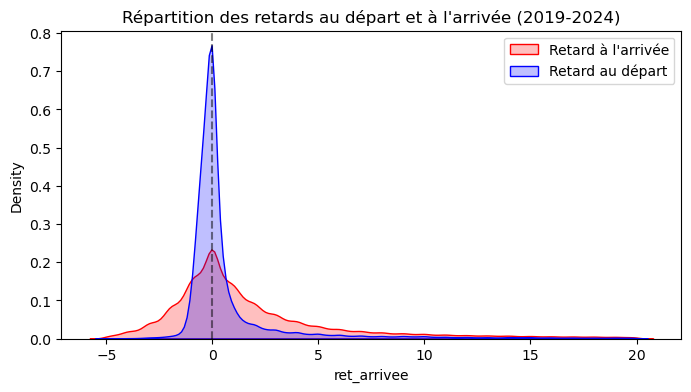

In [7]:
# Réparatition des retards au départ et à l'arrivée
plt.figure(figsize=(8,4))
sns.kdeplot(df[(df['ret_arrivee'] >= -5) & (df['ret_arrivee'] <= 20)]['ret_arrivee'], fill=True, bw_adjust=1, color='r')
sns.kdeplot(df[(df['ret_depart'] >= -5) & (df['ret_depart'] <= 20)]['ret_depart'], fill=True, bw_adjust=1, color='b')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.legend(["Retard à l'arrivée", "Retard au départ"])
plt.title("Répartition des retards au départ et à l'arrivée (2019-2024)")

# Constats : 
# - les trains sont nettement plus ponctuels au départ qu'à l'arrivée, indiquant une possible accumulation de retard au fil du trajet.
# - distribution asymétrique à droite : les trains sont plus souvent en retard (x>0) qu'en avance (x<0).

Text(0.5, 1.0, "Répartition des retards à l'arrivée selon la durée du trajet (2019-2024)")

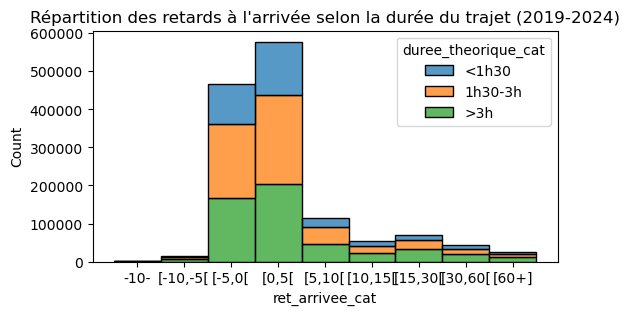

In [8]:
# Répartition des retards à l'arrivée selon la durée du trajet
plt.figure(figsize=(6,3))
sns.histplot(data=df, x="ret_arrivee_cat", hue="duree_theorique_cat", multiple="stack", stat="count")
plt.title("Répartition des retards à l'arrivée selon la durée du trajet (2019-2024)")

Text(0.5, 1.0, "Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée (2019-2024)")

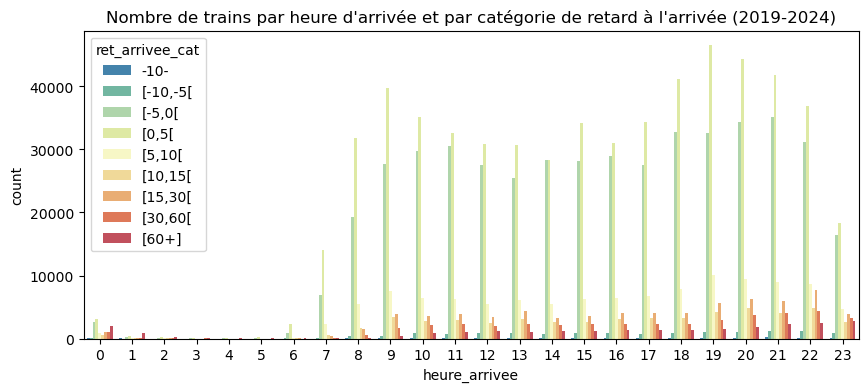

In [9]:
# Affiche le nombre de ret_arrivee_cat par heure_arrivee
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='heure_arrivee', hue='ret_arrivee_cat', palette=palette)
plt.title("Nombre de trains par heure d'arrivée et par catégorie de retard à l'arrivée (2019-2024)")

Text(0.5, 1.0, "Nombre de trains par mois et par catégorie de retard à l'arrivée (2019-2024)")

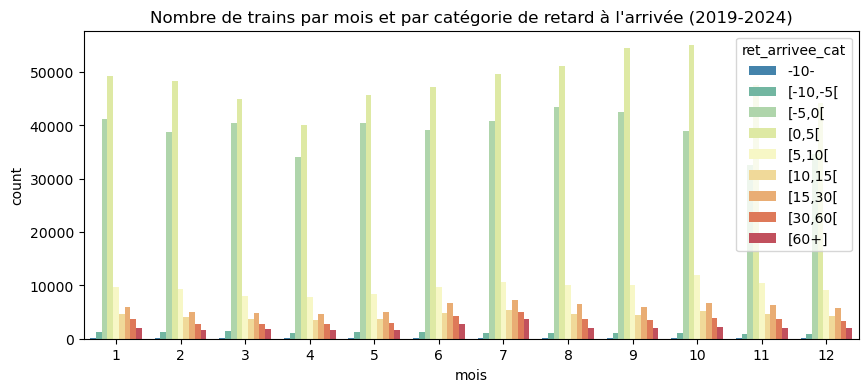

In [10]:
# Affiche le nombre de ret_arrivee_cat par mois
palette = sns.color_palette("Spectral", n_colors=len(df['ret_arrivee_cat'].cat.categories))[::-1]
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='mois', hue='ret_arrivee_cat', palette=palette)
plt.title("Nombre de trains par mois et par catégorie de retard à l'arrivée (2019-2024)")

# Retard par région d'arrivée

In [32]:
# Taux de retard à l'arrivée, selon la région d'arrivée
retard_5min_mensuel = df.groupby(['region_destination']).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).reset_index()
retard_5min_mensuel.sort_values(by='taux_retard_5min', ascending=False).style.background_gradient(cmap='coolwarm')

,region_destination,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
11,Provence-Alpes-Côte d'Azur,7.925157,1.333333,0.273123,0.181299,0.139768,0.072787,0.028097,83889
9,Occitanie,7.236488,0.083333,0.262345,0.184440,0.142149,0.076121,0.030415,65593
0,Auvergne-Rhône-Alpes,5.825913,1.166667,0.238402,0.139611,0.099940,0.047411,0.016665,136572
6,Ile-de-France,5.556328,1.000000,0.236752,0.143788,0.101039,0.047649,0.017484,522365
8,Nouvelle-Aquitaine,5.194098,0.583333,0.234553,0.135777,0.093249,0.043026,0.016496,80323
7,Normandie,5.807077,-1.000000,0.213568,0.172111,0.145729,0.082286,0.027638,1592
10,Pays de la Loire,5.681697,0.200000,0.211939,0.136524,0.101859,0.051845,0.021772,62282
1,Bourgogne-Franche-Comté,5.731590,0.983333,0.207225,0.126614,0.093273,0.048620,0.018486,11847
5,Hauts-de-France,5.259660,0.633333,0.206860,0.137470,0.100989,0.050428,0.018370,174089
2,Bretagne,4.921733,0.183333,0.195803,0.120381,0.087664,0.042986,0.016975,78584


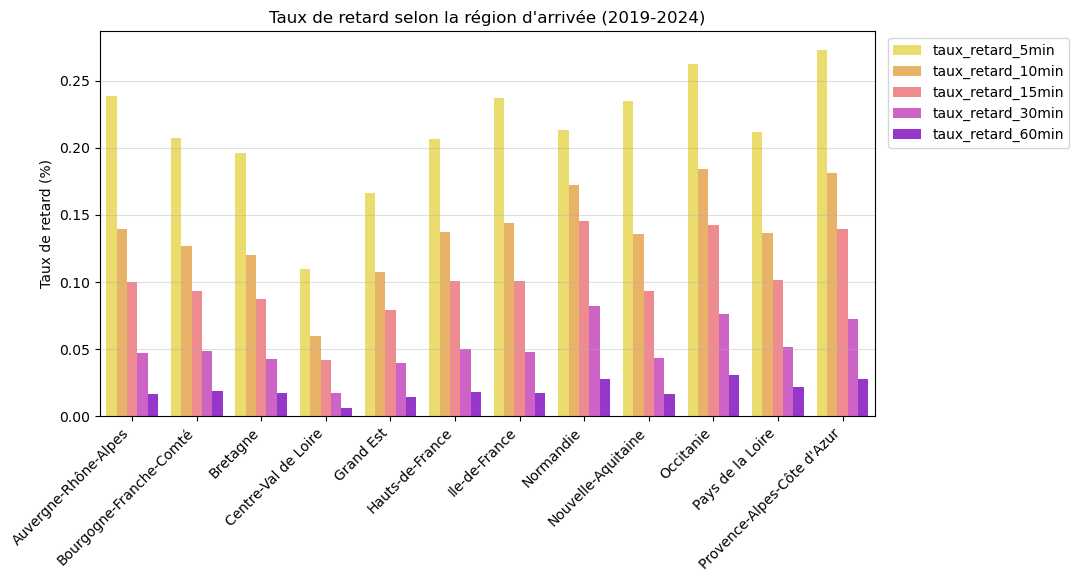

In [161]:
# petit graphique des taux de retard à l'arrivée par région (bar plot, groupé par région, 1 barre par taux de retard : 5, 10, 15, 30, 60 minutes)
plt.figure(figsize=(10, 5))
colors = colors = ["#ffec58", "#ffb553", "#fe7b82", "#df51d3", "#9f1de4"]
retard_5min_mensuel_melted = retard_5min_mensuel.melt(id_vars=['region_destination'], 
                                                      value_vars=['taux_retard_5min', 'taux_retard_10min', 'taux_retard_15min', 'taux_retard_30min', 'taux_retard_60min'],
                                                      var_name='délai', value_name='taux_retard')
sns.barplot(data=retard_5min_mensuel_melted, x='region_destination', y='taux_retard', hue='délai', palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title("Taux de retard selon la région d'arrivée (2019-2024)")
plt.legend(title='', loc='upper right', bbox_to_anchor=(1.26, 1))
plt.xlabel("")
plt.ylabel("Taux de retard (%)")
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.show()

# Retard par axe majeur (depuis Paris)

In [11]:
# Taux de retard TAGV par axe majeur DEPUIS PARIS
TAGV_depuis_paris = df[df['lib_ci_origine'].str.startswith("Paris") & df['lib_tct_arrivee'].str.startswith("TAGV")].copy()
TAGV_depuis_paris['Axe'] = TAGV_depuis_paris['lib_tct_arrivee'].map({
    'TAGV - Sud-Est, à charge': 'Sud-Est',
    'TAGV - Atlantique, à charge': 'Atlantique',
    'TAGV (Train A Grande Vitesse - à charge)': 'Inconnu',
    'TAGV - Est, à charge': 'Est',
    'TAGV - Nord, à charge': 'Nord',
    'TAGV International France Suisse, à charge': 'Suisse',
    'TAGV, axe Bretagne, à charge': 'Bretagne',
    'TAGV International France Allemagne, à charge': 'Allemagne',
    'TAGV haute capacité Sud-Est, à charge': 'Sud-Est (HC)',
    'TAGV haute capacité Atlantique, à charge': 'Atlantique (HC)',
    'TAGV International France Espagne, à charge': 'Espagne',
    'TAGV haute capacité Est, à charge': 'Est (HC)',
    'TAGV International France Italie, à charge': 'Italie',
    'TAGV international France Angleterre, à charge': 'Angleterre'
})
# tous les trains d'axe 'inconnu' sont en fait opérés par Thalys ou Trenitalia
# on va leur faire des catégories plus précises en fonction de leur département de destination
TAGV_depuis_paris.loc[
    (TAGV_depuis_paris['Axe'] == 'Inconnu') & (TAGV_depuis_paris['region_destination'] == 'Hauts-de-France'), 
    'Axe'
] = 'Nord (Thalys)'
TAGV_depuis_paris.loc[
    (TAGV_depuis_paris['Axe'] == 'Inconnu') & (TAGV_depuis_paris['region_destination'] == 'Auvergne-Rhône-Alpes'), 
    'Axe'
] = 'Sud-Est (Trenitalia)'

retard_par_axe = TAGV_depuis_paris.groupby('Axe').agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
retard_par_axe.reset_index(inplace=True)
retard_par_axe.sort_values(by='taux_retard_15min', ascending=False, inplace=True)
retard_par_axe.style.background_gradient(cmap='coolwarm')

# constats :
# - trains haute capacité (HC) sont moins ponctuels que trains classiques
# - lignes internationales plus en retard que lignes nationales : Angleterre, Espagne, Italie...
# - à l'excpetion de la Suisse et Allemagne
# - axes les plus ponctuels : Trenitalia, Est, Nord, 

,Axe,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
1,Angleterre,8.734831,2.408333,0.363281,0.238281,0.175781,0.093750,0.023438,256
5,Espagne,8.791473,1.050000,0.324733,0.228446,0.173065,0.082442,0.035242,1589
9,Italie,8.657171,2.000000,0.364385,0.226770,0.158080,0.076688,0.024935,4251
13,Sud-Est (HC),7.915553,0.816667,0.254351,0.174335,0.137528,0.077215,0.029806,9998
3,Atlantique (HC),6.992895,0.000000,0.231983,0.160368,0.122574,0.073317,0.034729,8811
15,Suisse,6.638345,1.016667,0.231972,0.159614,0.122428,0.058375,0.020456,16377
4,Bretagne,5.420534,0.000000,0.200468,0.131786,0.100854,0.051943,0.020047,14516
12,Sud-Est,5.455303,0.700000,0.213528,0.132590,0.097762,0.049654,0.018106,117694
11,Nord (Thalys),4.765178,0.266667,0.174213,0.123015,0.096249,0.052169,0.019668,53538
7,Est (HC),4.353915,-0.350000,0.155017,0.116025,0.092249,0.054208,0.021398,2103


# Corrélations

REMARQUE IMPORTANTE : le coefficient de corrélation de Pearson utilisé ici n'a pas une grande pertinence vis-à-vis des données. Il mesure des relations linéaires entre variables, ce qui n'est pas nécessairement le cas dans nos données (ex : les retards augmentent lorsque la température est très faible, très élevée, mais diminuent entre les deux -> relation non linéaire)

In [12]:
# encodage des variables catégorielles
df_encoded = df.copy()
df_encoded = df_encoded.drop(columns=['ret_arrivee_cat']) 
for col in df_encoded.select_dtypes(include=['object','string','category']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# calcul des corrélations
df_encoded_corr = df_encoded.corr()

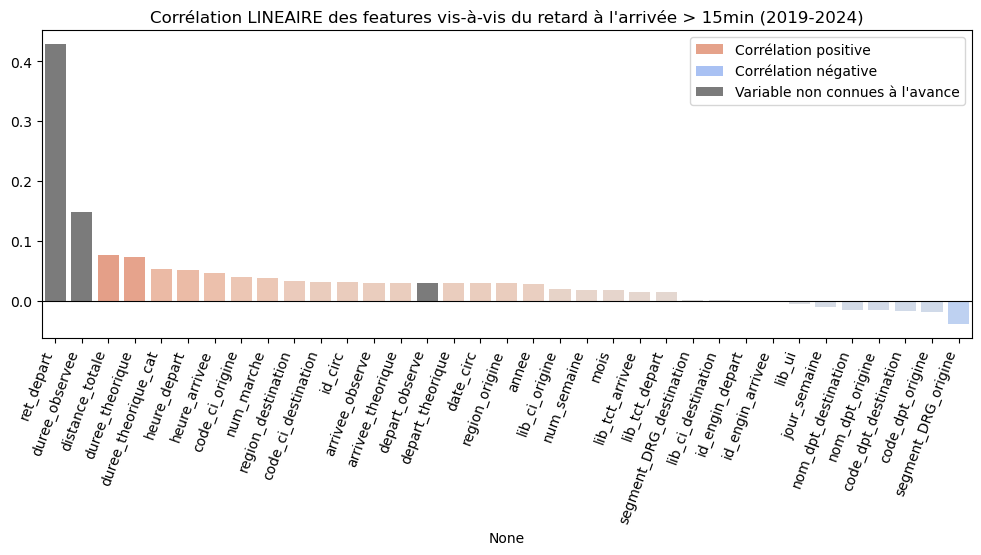

In [137]:
# Importance des features vis-à-vis du retard à l'arrivée > 15min

corr_series = df_encoded_corr.loc["ret_arrivee_15min"].sort_values(ascending=False)

# on exclut les colonnes non pertinentes (directement liées au retard à l'arrivée) :
corr_series = corr_series.drop(["ret_arrivee_60min", "ret_arrivee_30min", "ret_arrivee_15min", "ret_arrivee_10min", "ret_arrivee_5min", "ret_arrivee"], errors='ignore')

# dégradé de couleurs
norm = plt.Normalize(-0.15, 0.15)
colors = (plt.cm.coolwarm(norm(corr_series.values))).tolist()

# on passe en gris les colonnes non connues à l'avance 
unknown_cols = ["ret_depart", "duree_observee", "depart_observe", 'arrivee_observee']
for i, col in enumerate(corr_series.index):
    if col in unknown_cols:
        colors[i] = ("#7B7B7B")

plt.figure(figsize=(12, 4))
sns.barplot(
    x=corr_series.index,
    y=corr_series.values,
    hue=corr_series.index,
    palette=colors
)
plt.xticks(rotation=70, ha='right')
plt.title("Corrélation LINEAIRE des features vis-à-vis du retard à l'arrivée > 15min (2019-2024)")
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

# Légende
legend_elements = [
    Patch(facecolor="#e5a28a", label='Corrélation positive'),
    Patch(facecolor="#a9c1f3", label='Corrélation négative'),
    Patch(facecolor="#7B7B7B", label='Variable non connues à l\'avance')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()


# Retard selon distance totale

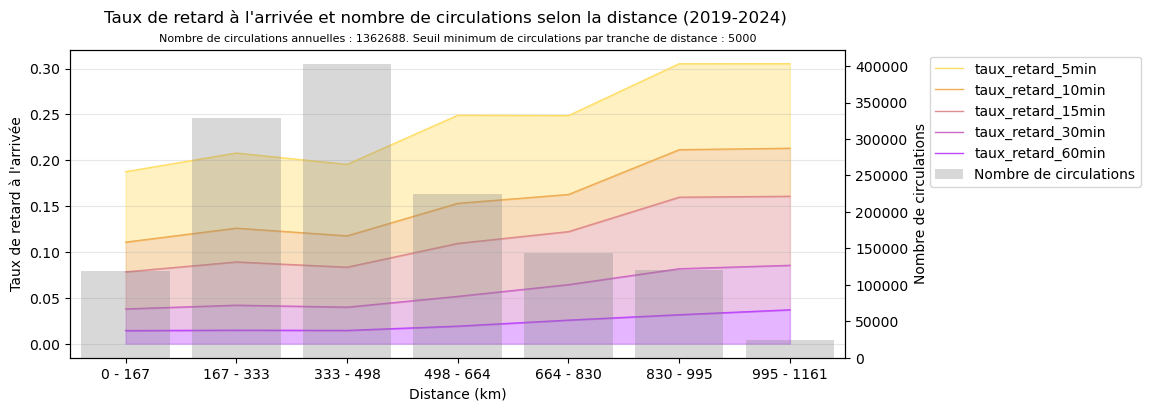

In [14]:
# Taux de ratrd selon la distance
df_distances = df.copy()

seuil_trajets = 5000 # nombre minimal de trajets pour considérer la donnée comme pertinente

# Ajout d'une variable catégorielle pour la distance
df_distances['distance_totale_cat'] = pd.cut(df_distances['distance_totale'], bins=10)

# Probabilité d'être en retard à l'arrivée selon la distance
stats = df_distances.groupby(["distance_totale_cat"], observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

stats = stats.reset_index()

# élimine les tranches de distance avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil_trajets]

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon la distance (2019-2024)")
plt.title(f"Nombre de circulations annuelles : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche de distance : {seuil_trajets}", fontsize=8)
plt.xlabel("Distance (km)")

# Taux de retard
ax = plt.gca()
colors = ["#ffde66", '#efad57', '#df8b8f', '#cf69c7', '#bf47ff']
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = [f"{int(interval.left/1000)} - {int(interval.right/1000)}" for interval in stats["distance_totale_cat"]]
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()

# constat : le taux de retard semble légèrement augmenter avec la distance

# Retard par mois

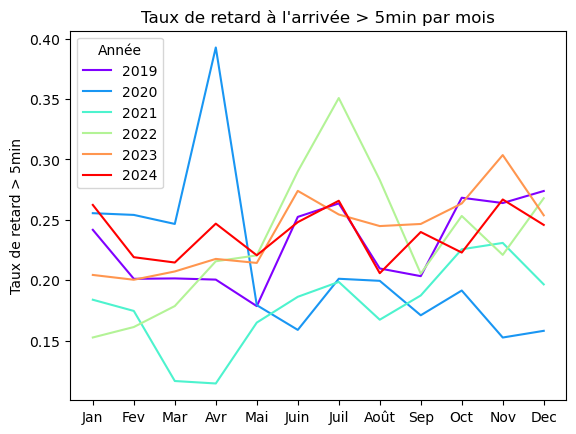

In [15]:
# analyse du taux de retard 5min mensuel par année

colors = plt.cm.rainbow(np.linspace(0, 1, 6))
for i, annee in enumerate([2019, 2020, 2021, 2022, 2023, 2024]):
    stats = df[df['annee'] == annee].groupby('mois').agg(
        taux_retard_5min = ('ret_arrivee_5min', 'mean')
    )
    stats.index = stats.index.astype(str)
    plt.plot(stats.index, stats['taux_retard_5min'], label=str(annee), color=colors[i])
plt.title("Taux de retard à l'arrivée > 5min par mois")
plt.ylabel("Taux de retard > 5min")
plt.legend(title="Année")
x_labels = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Dec']
plt.gca().set_xticks(range(len(x_labels)))
plt.gca().set_xticklabels(x_labels, fontsize=10)
plt.show()

# constat : 

# impact des confinements :
#    - mars 2020 : premier confinement, explosion des retards

# note : on retombe exactement sur les mêmes courbes que celles présentées par LeMonde en 2023, à partir des données fournies par l'ART !! :))))

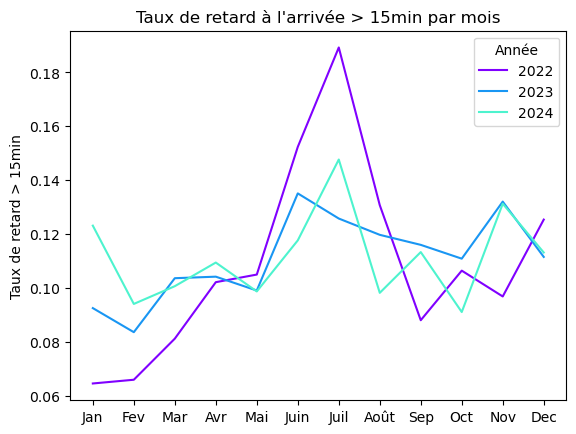

In [16]:
# analyse du taux de retard 15min mensuel

colors = plt.cm.rainbow(np.linspace(0, 1, 6))
for i, annee in enumerate([2022, 2023, 2024]):
    stats = df[df['annee'] == annee].groupby(['mois']).agg(
        taux_retard_15min = ('ret_arrivee_15min', 'mean')
    )
    stats.index = stats.index.astype(str)
    plt.plot(stats.index, stats['taux_retard_15min'], label=str(annee), color=colors[i])
plt.title("Taux de retard à l'arrivée > 15min par mois")
plt.ylabel("Taux de retard > 15min")
plt.legend(title="Année")
x_labels = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Dec']
plt.gca().set_xticks(range(len(x_labels)))
plt.gca().set_xticklabels(x_labels, fontsize=10)
plt.show()

# constat : 

# impact des confinements :
#    - mars 2020 : premier confinement, explosion des retards


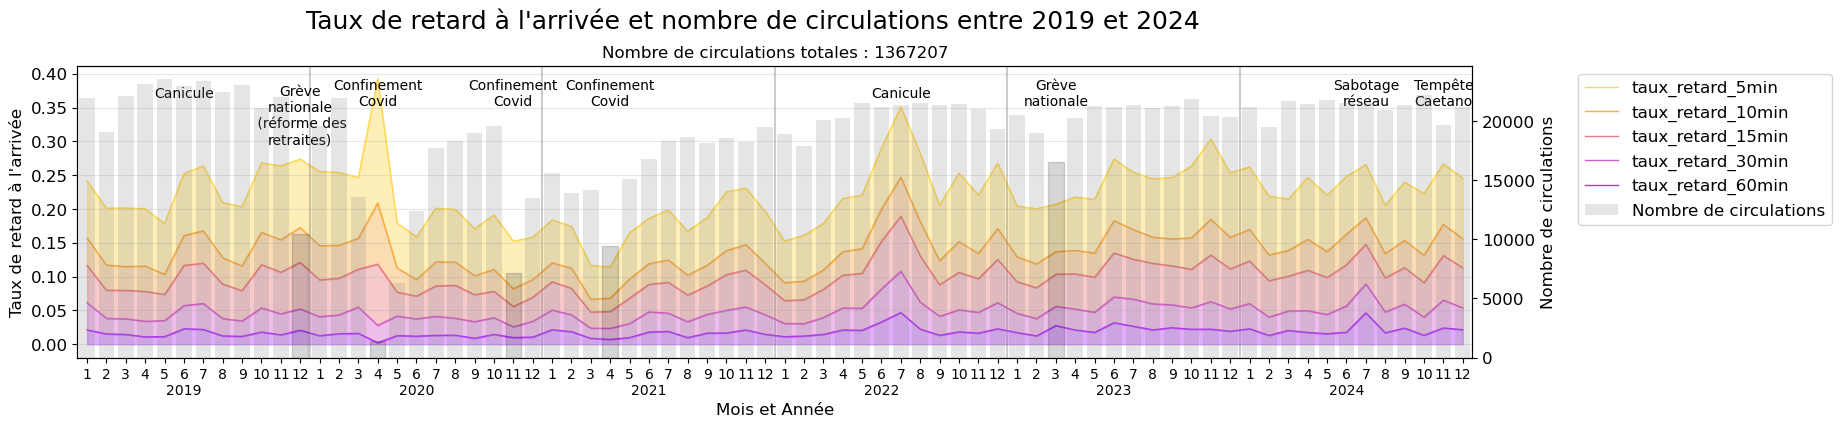

In [148]:
# Taux de retard mensuels entre 2019 et 2024

stats = df.groupby(['annee', 'mois']).agg(
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
stats = stats.reset_index()
stats["mois"] = stats["mois"].astype(str)
stats["annee"] = stats["annee"].astype(str)

# Graphique
plt.figure(figsize=(18, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations entre 2019 et 2024", fontsize=18)
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}", fontsize=12)
plt.subplots_adjust(top=0.84) # augmente l'espace entre le suptitle et le title
plt.xlabel("Mois et Année")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min", 
                         "taux_retard_30min", "taux_retard_60min"]],
            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(range(len(stats)), stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.2, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende unifiée
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.07, 1), fontsize=12)

# Labels
# x_labels = [f"{mois}\n{i}" for i, mois in enumerate(stats["mois"].astype(str).tolist())] # pour debug : ajoute l'index au label
x_labels = stats["mois"].astype(str).tolist()
for i, ligne in enumerate(stats.values):
    if ligne[1] == '6':
        x_labels[i] += f"\n{ligne[0]}"
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10, ha='center')

# Barres verticales entre chaque année
for i, ligne in enumerate(stats.values):
    if ligne[1] == '1' and i != 0:
        ax.axvline(i - 0.5, color='gray', linestyle='-', alpha=0.4, linewidth=1.5)


# augmente la taille de toutes les polices
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_yticklabels() + 
             [ax2.yaxis.label] + ax2.get_yticklabels()):
    item.set_fontsize(12)



# Annotations des événements majeurs

text_fontsize = 10

# juin 2019 : canicule
# https://www.franceinfo.fr/environnement/evenements-meteorologiques-extremes/vagues-de-chaleur-canicules/canicule-retards-et-trains-annules-a-la-sncf_3512397.html
ax.text(5, ax.get_ylim()[1]*0.9, 'Canicule', color='black', fontsize=text_fontsize, ha='center', va='center')

# mars 2023 : grève nationale SNCF majeure (53 jours de grève)
ax.text(11, ax.get_ylim()[1]*0.82, 'Grève\nnationale\n (réforme des\nretraites)', color='black', fontsize=text_fontsize, ha='center', va='center')
ax2.patches[11].set_color('#333333')

# 17 mars - 11 mai 2020 : confinement covid 1
ax.text(15, ax.get_ylim()[1]*0.9, 'Confinement\nCovid', color='black', fontsize=text_fontsize, ha='center', va='center')
ax2.patches[15].set_color('#333333')
# 30 octobre - 15 décembre 2020 : confinement covid 2
ax.text(22, ax.get_ylim()[1]*0.9, 'Confinement\nCovid', color='black', fontsize=text_fontsize, ha='center', va='center')
ax2.patches[22].set_color('#333333')
# 3 avril - 3 mai 2021 : confinement covid 3
ax.text(27, ax.get_ylim()[1]*0.9, 'Confinement\nCovid', color='black', fontsize=text_fontsize, ha='center', va='center')
ax2.patches[27].set_color('#333333')

# juillet 2022 : canicule
# https://www.lemonde.fr/climat/article/2022/07/23/comment-la-canicule-malmene-les-infrastructures-ferroviaires-et-oblige-les-trains-a-rouler-au-ralenti_6135838_1652612.html
# https://meteofrance.com/actualites-et-dossiers/actualites/canicule-intense-et-durable-de-juillet-2022-que-faut-il-retenir
ax.text(42, ax.get_ylim()[1]*0.9, 'Canicule', color='black', fontsize=text_fontsize, ha='center', va='center')

# mars 2023 : grève nationale SNCF
ax.text(50, ax.get_ylim()[1]*0.9, 'Grève\nnationale', color='black', fontsize=text_fontsize, ha='center', va='center')
ax2.patches[50].set_color("#333333")

# juillet 2024 : sabotage réseau
# https://www.lemonde.fr/economie/article/2024/07/26/sncf-attaque-massive-contre-le-reseau-tgv-le-jour-des-jo_6258709_3234.html
ax.text(66, ax.get_ylim()[1]*0.9, 'Sabotage\nréseau', color='black', fontsize=text_fontsize, ha='center', va='center')

# novembre 2024 : tempête Caetano
# https://www.ouest-france.fr/meteo/neige/neige-et-verglas-de-nombreux-trains-en-retard-ou-supprimes-81c3adce-a822-11ef-9190-7abd4499cf18
# https://meteofrance.com/actualites-et-dossiers/actualites/tempete-caetano-un-episode-hivernal-precoce-avec-neige-en-plaine
ax.text(70, ax.get_ylim()[1]*0.9, 'Tempête\nCaetano', color='black', fontsize=text_fontsize, ha='center', va='center')


plt.show()

# constats :
# les plus gros retards sont causés par des évènements extrêmes non prévisibles. ne pourra pas être utilisé pour prédire les retard.
# à l'échelle mensuelle, difficile de dégager des tendances claires... sauf peut-être l'été, avec les canicules ?
# en revanche, des motifs se dégagent si on étudie à d'autres niveaux (par jour_semaine, par région, etc)

# Retard selon jour_semaine

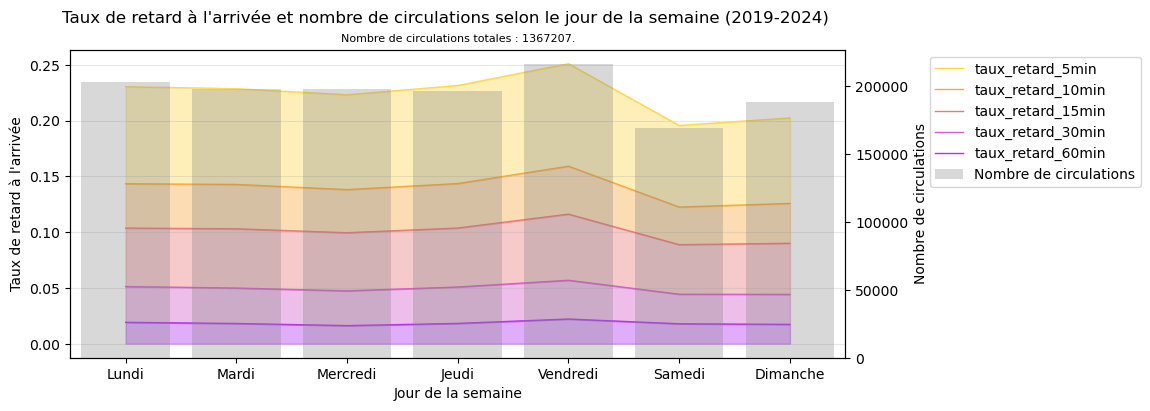

In [68]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine (2019-2024)

# Probabilité d'être en retard à l'arrivée selon le jour de la semaine
stats = df.groupby(["jour_semaine"]).agg(
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# considère le jour de la semaine comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard à l'arrivée et nombre de circulations selon le jour de la semaine (2019-2024)")
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}.", fontsize=8)
plt.xlabel("Jour de la semaine")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

# Labels
x_labels = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=10)

plt.show()

# constat : taux de retard plus élevé le vendredi, plus faible le weekend

# Retard selon jour_semaine et heure

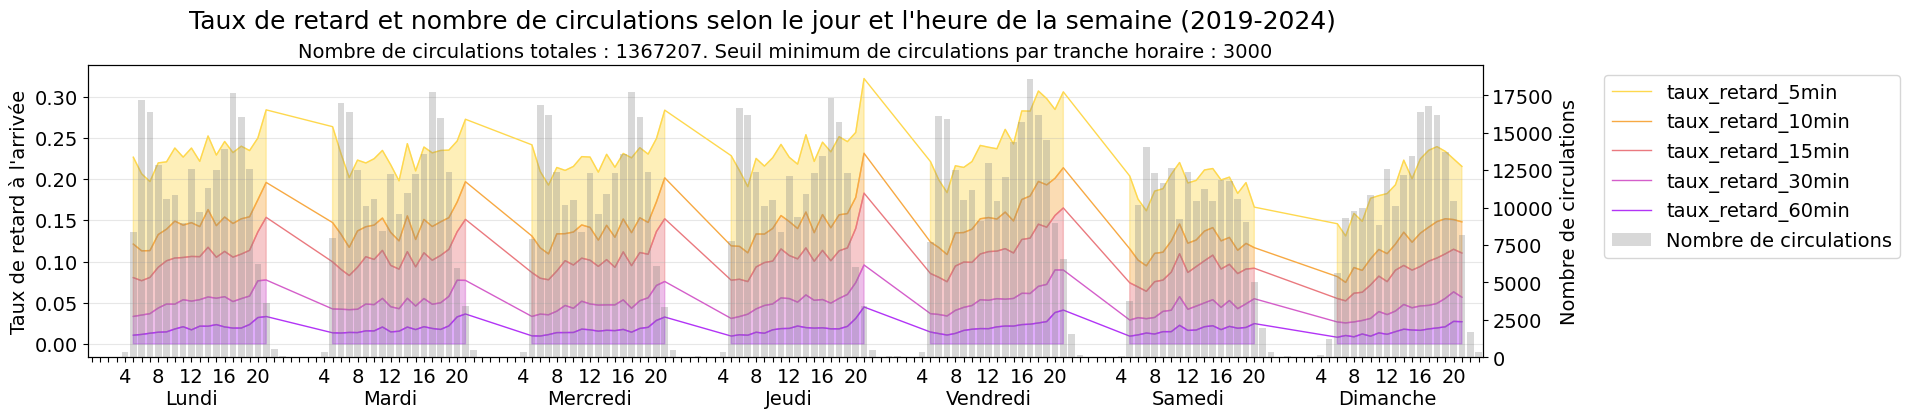

In [136]:
### Taux de retard à l'arrivée global et nombre de circulations selon le jour de la semaine ET l'heure de départ (2019-2024)

seuil = 3000

# Probabilité d'être en retard à l'arrivée selon le jour et l'heure de la semaine 
stats = df.groupby(["jour_semaine", "heure_depart"]).agg(
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)
stats = stats.reset_index(names=['jour_semaine','heure_depart'])

# quand le nb_circ < seuil, on va ici remplaver la valeur des taux de retard par NaN 
# (pour ne pas afficher les taux sur ces plages horaires, qui sont biaisés par le faible nombre de trajets)
stats.loc[stats["nb_circ"] < seuil,
          ["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
           "taux_retard_30min", "taux_retard_60min"]] = np.nan

# Graphique
plt.figure(figsize=(18, 4))
plt.suptitle(f"Taux de retard et nombre de circulations selon le jour et l'heure de la semaine (2019-2024)", fontsize=18)
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil}", fontsize=8)
plt.subplots_adjust(top=0.84) # augmente l'espace entre le suptitle et le title
#plt.xlabel("Jour de la semaine et heure")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min", 
                         "taux_retard_30min", "taux_retard_60min"]],
            palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(range(len(stats)), stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(range(len(stats)), stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Axe secondaire
ax2 = ax.twinx()
sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende unifiée
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.08, 1), fontsize=14)

# Labels
heures_interet = [4, 8, 12, 16, 20]
jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
x_labels = []
for ligne in stats.values:
    jour_num, heure = ligne[0], ligne[1]
    heure_label = f"{heure:.0f}" if heure in heures_interet else ""
    x_labels.append(f"{heure_label}\n{jours_semaine[int(jour_num)] if heure == 12 else ""}")
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, fontsize=14)

# augmente la taille de toutes les polices
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + 
             [ax2.yaxis.label] + ax2.get_yticklabels()):
    item.set_fontsize(14)

plt.show()

# constat : la tendance 2024 se confirme sur les autres années, avec 
# - un pic de retards le vendredi soir
# - des trains plus ponctuels le matin que le soir 
# - samedi jour le plus ponctuel de la semaine

# Retard selon heure

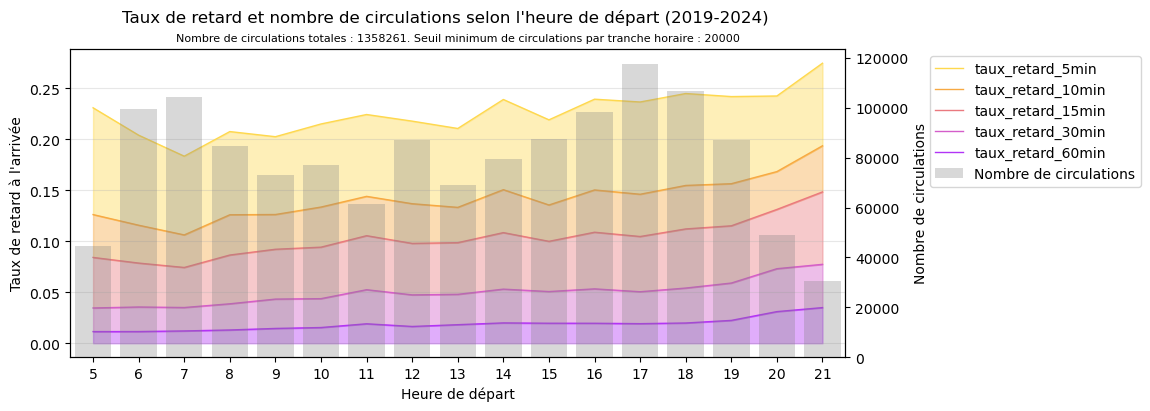

In [104]:
### Taux de retard à l'arrivée global et nombre de circulations selon l'heure de départ (2019-2024)

seuil = 20000

# Probabilité d'être en retard à l'arrivée selon l'heure de départ 
stats = df.groupby(["heure_depart"]).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
)

# élimine les heures avec peu de circulations pour éviter le bruit
stats = stats[stats["nb_circ"] > seuil]

# considère l'heure comme une chaine de caractères (pour l'affichage)
stats.index = stats.index.astype(str)

# Graphique :
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard et nombre de circulations selon l'heure de départ (2019-2024)")
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}. Seuil minimum de circulations par tranche horaire : {seuil}", fontsize=8)
plt.xlabel("Heure de départ")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# constat : la tendance 2024 se confirme, avec des trains du matin (6-9h) globalement plus ponctuels que les trains du soir (16-21h)

# Retard selon météo (2022-2024)

L'analyse se focalise sur 2022-2024, afin d'éviter l'impact massif du Covid-19 sur les données.
Cela constitue tout de même un échantillon plus large que la seule année 2024, comme dans `2-EDA-2024.ipynb`

In [21]:
# import données météo 2022-2024
meteo = pd.read_parquet("../data/2-clean/meteo/meteo_france_2022-2024.parquet")

# drop les colonnes avec quasiment aucune donnée
meteo = meteo.drop(columns=['tornado', 'hail'])

In [22]:
# Complète le df principal via jointure sur 'region' et 'DATE' 
df_meteo = df.copy()
df_meteo = df_meteo.merge(meteo, how='left', left_on=['region_destination', 'date_circ'], right_on=['region', 'DATE'])

In [88]:
# restreint à 2022-2024 pour coller aux données météo
df_meteo = df_meteo[(df_meteo['annee'] >= 2022) & (df_meteo['annee'] <= 2024)].copy()

<Axes: >

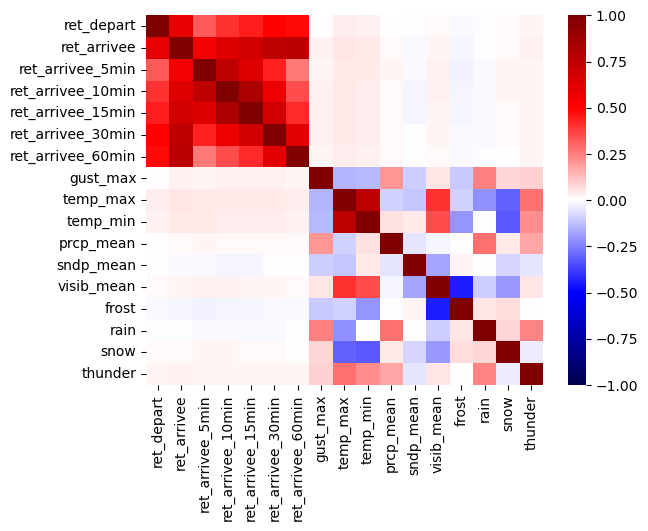

In [89]:
# Heatmap de corrélation des variables de retard et la météo
corr_map = df_meteo[['ret_depart', 'ret_arrivee', 'ret_arrivee_5min', 'ret_arrivee_10min', 
                    'ret_arrivee_15min', 'ret_arrivee_30min', 'ret_arrivee_60min', 
                    'gust_max', 'temp_max', 'temp_min', 'prcp_mean', 'sndp_mean',
                    'visib_mean', 'frost', 'rain', 'snow', 'thunder']].corr()

sns.heatmap(corr_map, annot=False, fmt=".2f", cmap="seismic", vmax=1, vmin=-1)
# constat : sur 3 ans comme sur 1 an, les corrélations restent très faibles.

# NOTE : le coefficient de corrélation utilisé (Pearson) mesure des corrélations LINEAIRES, ce qui n'est pas nécessairement le cas ici. Cet indicateur n'est pas le plus adapté à notre cas, et sera nuancé par les analyses plus détaillées ci dessous

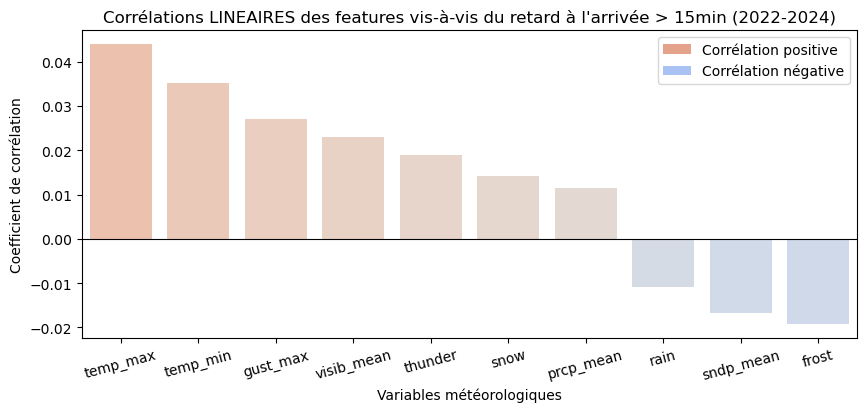

In [90]:
# Importance des variables météorologiques vis-à-vis du retard à l'arrivée > 15min
corr_series = corr_map.loc["ret_arrivee_15min"].sort_values(ascending=False)
# on exclut les colonnes non pertinentes (directement liées au retard à l'arrivée) :
corr_series = corr_series.drop(["ret_depart", "ret_arrivee_60min", "ret_arrivee_30min", "ret_arrivee_15min", "ret_arrivee_10min", "ret_arrivee_5min", "ret_arrivee"], errors='ignore')

# dégradé de couleurs
norm = plt.Normalize(-0.15, 0.15)
colors = (plt.cm.coolwarm(norm(corr_series.values))).tolist()

# graphique
plt.figure(figsize=(10, 4))
sns.barplot(x=corr_series.index,
            y=corr_series.values,
            hue=corr_series.index,
            palette=colors)
plt.xticks(rotation=15, ha='center')
plt.title("Corrélations LINEAIRES des features vis-à-vis du retard à l'arrivée > 15min (2022-2024)")
plt.axhline(0, color='black', linestyle='-', linewidth=0.8)

# légende
legend_elements = [Patch(facecolor="#e5a28a", label='Corrélation positive'),
                   Patch(facecolor="#a9c1f3", label='Corrélation négative')]
plt.legend(handles=legend_elements, loc='upper right')
plt.xlabel("Variables météorologiques")
plt.ylabel("Coefficient de corrélation")

plt.show()

# Constat : comme pour 2024, les corrélations sont quasi nulles, car comprises entre -0.02 et 0.04

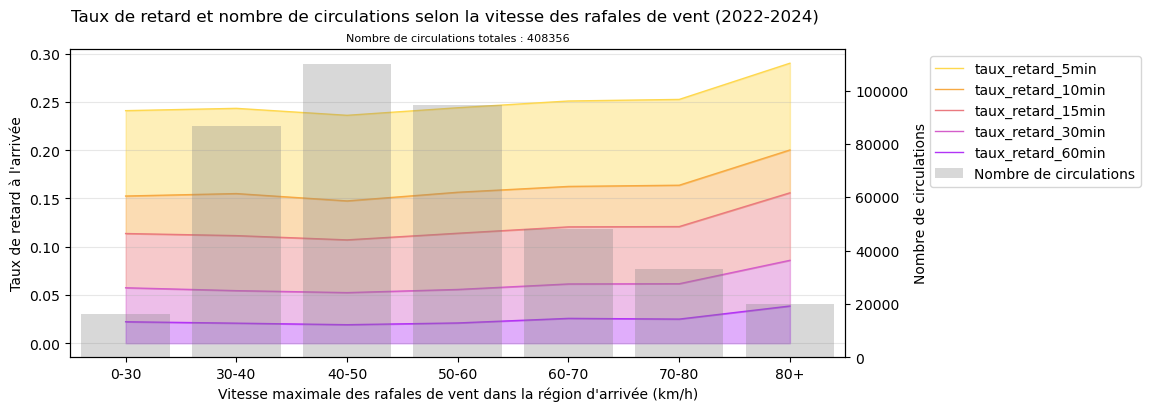

In [98]:
# répartit les rafales de vent en catégories
df_gust = df_meteo.copy()
#df_gust['gust_max'] = df_gust['gust_max'].fillna(0)
bins = [0, 30, 40, 50, 60, 70, 80, float('inf')]
labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+']
df_gust['gust_cat'] = pd.cut(df_gust['gust_max'], bins=bins, labels=labels, right=False)

# taux de retard selon la vitesse des rafales
stats = df_gust.groupby('gust_cat', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard et nombre de circulations selon la vitesse des rafales de vent (2022-2024)")
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Vitesse maximale des rafales de vent dans la région d'arrivée (km/h)")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()



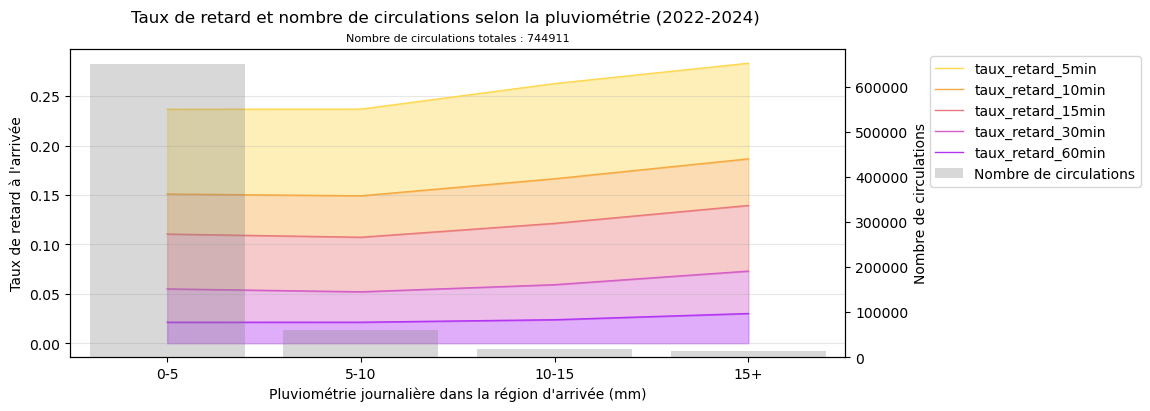

In [100]:
# taux de retard selon la pluviométrie :

# Répartition de la pluviométrie
# plt.figure(figsize=(4, 2))
# sns.histplot(df_copy['prcp_mean'].dropna(), bins=30, kde=False)
# df_copy['prcp_mean'].describe()

# répartit la pluviométrie en catégories
df_prcp = df_meteo.copy()
df_prcp['prcp_mean'] = df_prcp['prcp_mean'].fillna(0)
bins = [0, 5, 10, 15, float('inf')]
labels = ['0-5', '5-10', '10-15', '15+']
df_prcp['prcp_mean'] = pd.cut(df_prcp['prcp_mean'], bins=bins, labels=labels, right=False)

# taux de retard selon la pluviométrie
stats = df_prcp.groupby('prcp_mean', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard et nombre de circulations selon la pluviométrie (2022-2024)")
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Pluviométrie journalière dans la région d'arrivée (mm)")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# constat : augmentation légère, mais constante, du taux de retard à l'arrivée avec l'augmentation de la pluviométrie.
# le nombre de circulations pour les fortes pluies peut sembler faible, en raison de la rareté de ces évènements, mais
# il convient tout de même de noter que la catégorie "15+" comptabilise tout de même 14_337 circulations, ce qui est loin d'être anecdotique, et 19_299 pour 10-15mm.

In [93]:
stats['nb_circ']

prcp_mean
0-5      650238
5-10      61037
10-15     19299
15+       14337
Name: nb_circ, dtype: int64

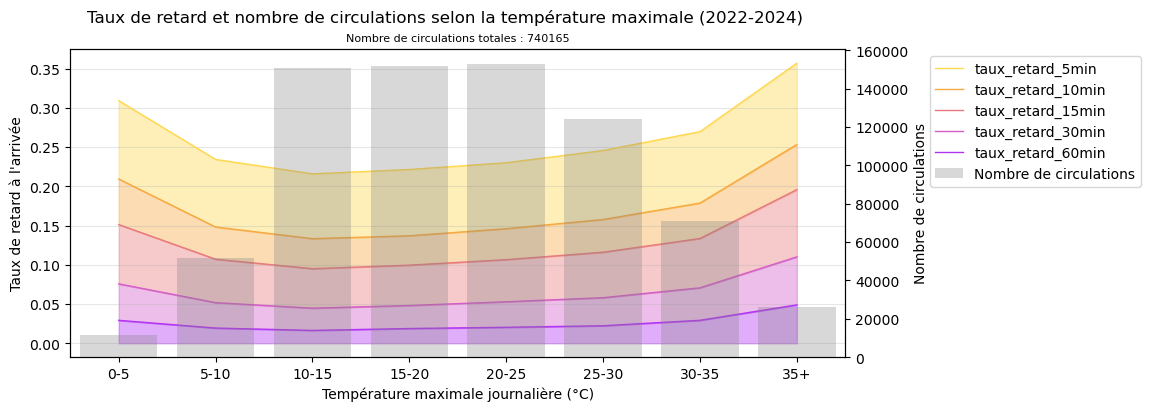

In [101]:
# taux de retard selon la température max

# effet attendu : retards causés par températures extremes (causant dilatation des rails, etc)

# D'abord, analyse de la répartition de la température
# plt.figure(figsize=(4, 2))
# sns.histplot(df_copy['temp_max'].dropna(), bins=10, kde=False)
# df_copy['temp_max'].describe()

# répartit la température max en catégories
df_temp_max = df_meteo.copy()
#df_temp_max['temp_max'] = df_temp_max['temp_max'].fillna(0)
bins = [0, 5, 10, 15, 20, 25, 30, 35, float('inf')]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35+']
df_temp_max['temp_max'] = pd.cut(df_temp_max['temp_max'], bins=bins, labels=labels, right=False)

# taux de retard selon la température max
stats = df_temp_max.groupby('temp_max', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard et nombre de circulations selon la température maximale (2022-2024)")
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Température maximale journalière (°C)")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()

# constat :
# - le taux de retard augmente significativement lorsque les températures max sont faibles (<5°C), et lorsqu'elles sont élevées (>30°C)

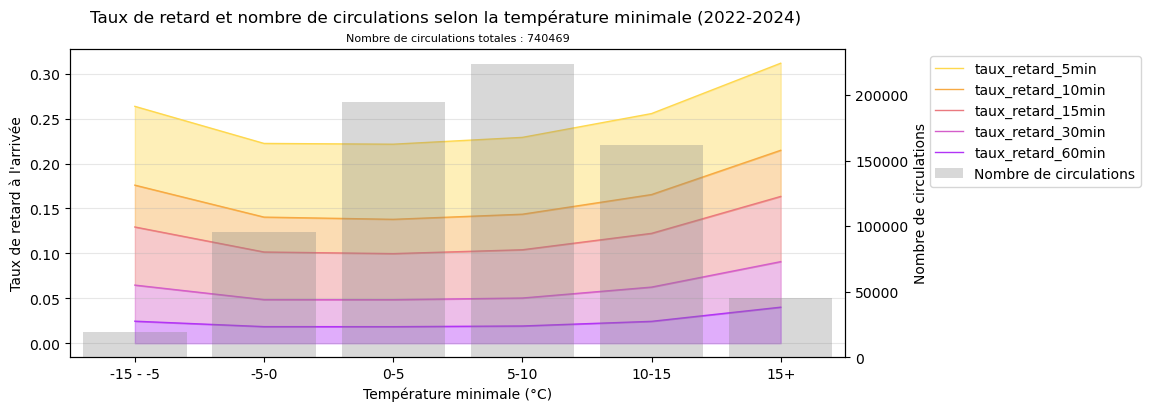

In [103]:
# taux de retard selon la température min

# effet attendu : retards causés par températures extremes (causant dilatation des rails, etc)

# D'abord, analyse de la répartition de la température
# plt.figure(figsize=(4, 2))
# sns.histplot(df_copy['temp_min'].dropna(), bins=10, kde=False)
# df_copy['temp_min'].describe()

# répartit la température min en catégories
df_temp_min = df_meteo.copy()
bins = [-15, -5, 0, 5, 10, 15, float('inf')]
labels = ['-15 - -5', '-5-0', '0-5', '5-10', '10-15', '15+']
df_temp_min['temp_min'] = pd.cut(df_temp_min['temp_min'], bins=bins, labels=labels, right=False)


# taux de retard selon la température min
stats = df_temp_min.groupby('temp_min', observed=False).agg(
    retard_arrivee_moyen = ('ret_arrivee', 'mean'),
    retard_arrivee_median = ('ret_arrivee', 'median'),
    taux_retard_5min = ('ret_arrivee_5min', 'mean'),
    taux_retard_10min = ('ret_arrivee_10min', 'mean'),
    taux_retard_15min = ('ret_arrivee_15min', 'mean'),
    taux_retard_30min = ('ret_arrivee_30min', 'mean'),
    taux_retard_60min = ('ret_arrivee_60min', 'mean'),
    nb_circ = ('id_circ', 'count')
).sort_index()

# Graphique
plt.figure(figsize=(10, 4))
plt.suptitle(f"Taux de retard et nombre de circulations selon la température minimale (2022-2024)")
plt.title(f"Nombre de circulations totales : {stats['nb_circ'].sum()}", fontsize=8)
plt.xlabel("Température minimale (°C)")

# Taux de retard
ax = plt.gca()
colors = ["#fed84e", "#f7a943", "#ea797f", "#d45eca", "#b234f6"]
lineplot = sns.lineplot(data=stats[["taux_retard_5min", "taux_retard_10min", "taux_retard_15min",
                                    "taux_retard_30min", "taux_retard_60min"]], 
                        palette=colors, dashes=False, markers=False, linewidth=1, ax=ax)
ax.fill_between(stats.index, stats["taux_retard_5min"], stats["taux_retard_10min"], color=colors[0], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_10min"], stats["taux_retard_15min"], color=colors[1], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_15min"], stats["taux_retard_30min"], color=colors[2], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_30min"], stats["taux_retard_60min"], color=colors[3], alpha=0.4)
ax.fill_between(stats.index, stats["taux_retard_60min"], 0, color=colors[4], alpha=0.4)
ax.set_ylabel("Taux de retard à l'arrivée")
ax.grid(axis='y', alpha=0.3)

# Nombre de circulations
ax2 = ax.twinx()
barplot = sns.barplot(data=stats["nb_circ"], ax=ax2, color="gray", alpha=0.3, label="Nombre de circulations")
ax2.set_ylabel("Nombre de circulations")

# Légende
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.1, 1))

plt.show()


In [96]:
for event in ['thunder', 'snow', 'rain', 'frost']:
    stats = df_meteo.groupby(event).agg(
        retard_arrivee_moyen = ('ret_arrivee', 'mean'),
        retard_arrivee_median = ('ret_arrivee', 'median'),
        taux_retard_5min = ('ret_arrivee_5min', 'mean'),
        taux_retard_10min = ('ret_arrivee_10min', 'mean'),
        taux_retard_15min = ('ret_arrivee_15min', 'mean'),
        taux_retard_30min = ('ret_arrivee_30min', 'mean'),
        taux_retard_60min = ('ret_arrivee_60min', 'mean'),
        nb_circ = ('id_circ', 'count')
    )
    print(f"Stats for {event}:")
    display(stats)

Stats for thunder:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
thunder,,,,,,,,
False,6.04,0.88,0.24,0.15,0.11,0.05,0.02,652082
True,7.56,1.00,0.26,0.17,0.13,0.07,0.03,88450


Stats for snow:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
snow,,,,,,,,
False,6.17,0.88,0.24,0.15,0.11,0.05,0.02,703944
True,7.21,1.10,0.27,0.18,0.13,0.07,0.03,36588


Stats for rain:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
rain,,,,,,,,
False,6.38,0.92,0.24,0.16,0.12,0.06,0.02,239987
True,6.15,0.88,0.24,0.15,0.11,0.05,0.02,500545


Stats for frost:


,retard_arrivee_moyen,retard_arrivee_median,taux_retard_5min,taux_retard_10min,taux_retard_15min,taux_retard_30min,taux_retard_60min,nb_circ
frost,,,,,,,,
False,6.48,0.98,0.25,0.16,0.12,0.06,0.02,473846
True,5.77,0.75,0.22,0.14,0.10,0.05,0.02,266686
